# 🎯 Semantic Density

<div style="background-color: rgba(200, 200, 200, 0.1); padding: 20px; border-radius: 8px; margin-bottom: 20px; border: 1px solid rgba(127, 127, 127, 0.2); max-width: 97.5%; overflow-wrap: break-word;">
  <p style="font-size: 16px; line-height: 1.6">
This demo illustrates a state-of-the-art uncertainty quantification (UQ) approach known as semantic density. The semantic density method combines elements of black-box UQ (which generates multiple responses from the same prompt) and white-box UQ (which uses token probabilities of those generated responses) to compute density values. Intuitively, semantic density combines both signals to estimate a probability distribution for scoring each response. This method was proposed by Qiu et al. (2024) and is demonstrated in this notebook.
  </p>
</div>
      
## 📊 What You'll Do in This Demo

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>1</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section1>Set up LLM and prompts.</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Set up LLM instance and load example data prompts.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 15px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>2</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section2>Generate LLM Responses and Confidence Scores</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Generate and score LLM responses to the example questions using the <code>SemanticDensity()</code> class.</p>
  </div>
</div>

<div style="display: flex; margin-bottom: 25px; align-items: center">
  <div style="background-color: #34a853; color: white; border-radius: 50%; width: 30px; height: 30px; display: flex; justify-content: center; align-items: center; margin-right: 15px; flex-shrink: 0"><strong>3</strong></div>
  <div>
    <p style="margin: 0; font-weight: bold"><a href=#section3>Evaluate Hallucination Detection Performance</a></p>
    <p style="margin: 0; color: rgba(95, 99, 104, 0.8)">Visualize model accuracy at different thresholds of the semantic density score. Compute precision, recall, and F1-score of hallucination detection.</p>
  </div>
</div>

## ⚖️ Advantages & Limitations

<div style="display: flex; gap: 20px">
  <div style="flex: 1; background-color: rgba(0, 200, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(0, 200, 0, 0.2)">
    <h3 style="color: #2e8b57; margin-top: 0">Pros</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Universal Compatibility:</strong> Works with any LLM</li>
      <li><strong>Intuitive:</strong> Easy to understand and implement</li>
      <li><strong>Response-wise:</strong> Evaluates the trustworthiness of each response separately</li>
    </ul>
  </div>
  
  <div style="flex: 1; background-color: rgba(200, 0, 0, 0.1); padding: 15px; border-radius: 8px; border: 1px solid rgba(200, 0, 0, 0.2)">
    <h3 style="color: #b22222; margin-top: 0">Cons</h3>
    <ul style="margin-bottom: 0">
      <li><strong>Higher Cost:</strong> Requires multiple generations per prompt</li>
      <li><strong>Slower:</strong> Multiple generations and comparison calculations increase latency</li>
      <li><strong>Internal Access Required:</strong> Needs access to token probabilities
    </ul>
  </div>
</div>

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

from uqlm.utils import load_example_dataset, plot_model_accuracies, Tuner
from uqlm.scorers import SemanticDensity

<a id='section1'></a>
## 1. Set up LLM and Prompts

In this demo, we will illustrate this approach using a set of short answer questions from the [SimpleQA benchmark](https://openai.com/index/introducing-simpleqa/). To implement with your use case, simply **replace the example prompts with your data**.  

In [ ]:
# Load example dataset (simpleqa)
simpleqa = load_example_dataset("simpleqa", n=200)
simpleqa.head()

Loading dataset - simpleqa...
Processing dataset...
Dataset ready!


,question,answer
0,"How much money, in euros, was the surgeon held...","120,000 euros"
1,What is the name of the former Prime Minister ...,Jóhanna Sigurðardóttir
2,To whom did Mehbooba Mufti Sayed contest the 2...,Hasnain Masoodi
3,In which year did Melbourne's Monash Gallery o...,2023
4,Who requested the Federal Aviation Administrat...,The Coast Guard


In [3]:
# Define prompts
INSTRUCTION = "You will be given a question. Return only the answer as concisely as possible without providing an explanation.\n"
prompts = [INSTRUCTION + prompt for prompt in simpleqa.question]

In this example, we use `ChatVertexAI` to instantiate our LLM, but any [LangChain Chat Model](https://js.langchain.com/docs/integrations/chat/) **that returns token probabilities** may be used. Be sure to **replace with your LLM of choice.**

<div style="background-color: rgba(200, 0, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(200, 0, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>❗ Warning:</strong> Semantic density cannot be computed unless the LLM you use returns token probabilities.
      </div>

In [4]:
# import sys
# !{sys.executable} -m pip install langchain-google-vertexai
from langchain_google_vertexai import ChatVertexAI

llm = ChatVertexAI(model_name="gemini-2.5-pro")

<a id='section2'></a>
## 2. Generate responses and confidence scores

### `SemanticDensity()` - Generate LLM responses and compute consistency-based confidence scores for each response.

#### 📋 Class Attributes

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 20%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Parameter</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Type & Default</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 55%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description</th>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">llm</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">BaseChatModel<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A langchain llm `BaseChatModel`. User is responsible for specifying temperature and other relevant parameters to the constructor of the provided `llm` object.</td>
  </tr>    
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">device</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or torch.device<br><code>default="cpu"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the device that NLI model use for prediction. Only applies to 'noncontradiction' scorer. Pass a torch.device to leverage GPU.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">system_prompt</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str or None<br><code>default="You are a helpful assistant."</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Optional argument for user to provide custom system prompt for the LLM.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_calls_per_min</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies how many API calls to make per minute to avoid rate limit errors. By default, no limit is specified.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">use_n_param</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">bool<br><code>default=False</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies whether to use <code>n</code> parameter for <code>BaseChatModel</code>. Not compatible with all <code>BaseChatModel</code> classes. If used, it speeds up the generation process substantially when <code>num_responses</code> is large.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">postprocessor</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">callable<br><code>default=None</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">A user-defined function that takes a string input and returns a string. Used for postprocessing outputs.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">sampling_temperature</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">float<br><code>default=1</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">The 'temperature' parameter for LLM model to generate sampled LLM responses. Must be greater than 0.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">nli_model_name</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="microsoft/deberta-large-mnli"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies which NLI model to use. Must be acceptable input to <code>AutoTokenizer.from_pretrained()</code> and <code>AutoModelForSequenceClassification.from_pretrained()</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">max_length</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">int<br><code>default=2000</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">Specifies the maximum allowed string length for LLM responses for NLI computation. Responses longer than this value will be truncated in NLI computations to avoid <code>OutOfMemoryError</code>.</td>
  </tr>
  <tr>
    <td style="font-weight: bold; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">return_responses</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">str<br><code>default="all"</code></td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">If a postprocessor is used, specifies whether to return only postprocessed responses, only raw responses, or both. Specified with 'postprocessed', 'raw', or 'all', respectively.</td>
  </tr>
</table>

#### 🔍 Parameter Groups

<div style="display: flex; gap: 20px; margin-bottom: 20px">
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 100, 200, 0.1); border-radius: 5px; border: 1px solid rgba(0, 100, 200, 0.2);">
    <p style="font-weight: bold">🧠 LLM-Specific</p>
    <ul>
      <li><code>llm</code></li>
      <li><code>system_prompt</code></li>
      <li><code>sampling_temperature</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(0, 200, 0, 0.1); border-radius: 5px; border: 1px solid rgba(0, 200, 0, 0.2);">
    <p style="font-weight: bold">📊 Confidence Scores</p>
    <ul>
      <li><code>nli_model_name</code></li>
      <li><code>postprocessor</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 150, 0, 0.1); border-radius: 5px; border: 1px solid rgba(200, 150, 0, 0.2);">
    <p style="font-weight: bold">🖥️ Hardware</p>
    <ul>
      <li><code>device</code></li>
    </ul>
  </div>
  <div style="flex: 1; padding: 10px; background-color: rgba(200, 0, 200, 0.1); border-radius: 5px; border: 1px solid rgba(200, 0, 200, 0.2);">
    <p style="font-weight: bold">⚡ Performance</p>
    <ul>
      <li><code>max_calls_per_min</code></li>
      <li><code>use_n_param</code></li>
    </ul>
  </div>
</div>

#### 💻 Usage Examples

```python
# Basic usage with default parameters
sd = SemanticDensity(llm=llm)

# Using GPU acceleration, default scorers
sd = SemanticDensity(llm=llm, device=torch.device("cuda"))

# High-throughput configuration with rate limiting
sd = SemanticDensity(llm=llm, max_calls_per_min=200, use_n_param=True) 
```

In [5]:
import torch

# Set the torch device
if torch.cuda.is_available():  # NVIDIA GPU
    device = torch.device("cuda")
elif torch.backends.mps.is_available():  # macOS
    device = torch.device("mps")
else:
    device = torch.device("cpu")  # CPU
print(f"Using {device.type} device")

Using cuda device


In [6]:
sd = SemanticDensity(
    llm=llm,
    max_calls_per_min=250,  # set value to avoid rate limit error
    device=device,  # use if GPU available
)

### 🔄 Class Methods

<table style="border-collapse: collapse; width: 100%; border: 1px solid rgba(127, 127, 127, 0.2);">
  <tr>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 25%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Method</th>
    <th style="background-color: rgba(200, 200, 200, 0.2); width: 75%; padding: 8px; text-align: left; border: 1px solid rgba(127, 127, 127, 0.2);">Description & Parameters</th>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">SemanticDensity.generate_and_score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Generate LLM responses, sampled LLM (candidate) responses, and compute density score for the provided prompts.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>prompts</code> - (<strong>list of str</strong>) A list of input prompts for the model.</li>
        <li><code>num_responses</code> - (<strong>int, default=5</strong>) The number of sampled responses used to compute consistency.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while generating and scoring responses.</li>    
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (prompts, responses, sampled responses, and density score) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Complete end-to-end uncertainty quantification when starting with prompts.
      </div>
    </td>
  </tr>
  <tr>
    <td style="font-weight: bold; vertical-align: top; padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">SemanticDensity.score</td>
    <td style="padding: 8px; border: 1px solid rgba(127, 127, 127, 0.2);">
      <p>Compute density score on provided LLM responses. Should only be used if responses and sampled responses are already generated.</p>
      <p><strong>Parameters:</strong></p>
      <ul>
        <li><code>responses</code> - (<strong>list of str</strong>) A list of LLM responses for the prompts.</li>
        <li><code>sampled_responses</code> - (<strong>list of list of str</strong>) A list of lists of sampled LLM responses for each prompt. These will be used to compute consistency scores by comparing to the corresponding response from <code>responses</code>.</li>
        <li><code>show_progress_bars</code> - (<strong>bool, default=True</strong>) If True, displays a progress bar while scoring responses.</li>  
      </ul>
      <p><strong>Returns:</strong> <code>UQResult</code> containing data (responses, sampled responses, and density score) and metadata</p>
      <div style="background-color: rgba(0, 200, 0, 0.1); padding: 8px; border-radius: 3px; margin-top: 10px; border: 1px solid rgba(0, 200, 0, 0.2); margin-right: 5px; box-sizing: border-box; width: 100%;">
        <strong>💡 Best For:</strong> Computing uncertainty scores when responses are already generated elsewhere.
      </div>
    </td>
  </tr>
</table>

In [7]:
results = await sd.generate_and_score(prompts=prompts, num_responses=5)

# # alternative approach: directly score if responses already generated
# results = sd.score(responses=responses, sampled_responses=sampled_responses)

Output()

In [8]:
result_df = results.to_df()
result_df.head(5)

,response,sampled_responses,prompt,semantic_density_value,multiple_logprob
0,"€120,000","[120,000 euros, €136,000, €120,000, €120,000, ...",You will be given a question. Return only the ...,0.864952,"[[{'token': '1', 'logprob': -0.021097537130117..."
1,Jóhanna Sigurðardóttir,"[Jóhanna Sigurðardóttir, Jóhanna Sigurðardótti...",You will be given a question. Return only the ...,0.992922,"[[{'token': 'J', 'logprob': -1.311223854827403..."
2,Hasnain Masoodi,"[Hasnain Masoodi, Hasnain Masoodi, Hasnain Mas...",You will be given a question. Return only the ...,0.993829,"[[{'token': 'Has', 'logprob': -3.5046916309511..."
3,2022,"[2024, 2022, 2023, 2022, 2022]",You will be given a question. Return only the ...,0.946121,"[[{'token': '0', 'logprob': -1.192238414660096..."
4,BP,"[BP, BP, BP, BP, BP]",You will be given a question. Return only the ...,0.992808,"[[{'token': 'BP', 'logprob': -2.62244770965480..."


<a id='section3'></a>
## 3. Evaluate Hallucination Detection Performance

To evaluate hallucination detection performance, we 'grade' the responses against an answer key. **If you are using your own prompts/questions, update the grading method accordingly**.

In [ ]:
# Populate correct answers and grade responses
def short_answer_grader(response: str, possible_answers) -> bool:
    """Check entailment of possible answers in a response"""
    # convert string to list if needed
    if isinstance(possible_answers, str):
        possible_answers = [possible_answers]
    #  iterate over the list items
    for s in possible_answers:
        if s.lower() in response.lower():
            return True
    return False


result_df["answer"] = simpleqa.answer
result_df["response_correct"] = [short_answer_grader(r, a) for r, a in zip(result_df["response"], simpleqa["answer"])]
result_df.head(5)

,response,sampled_responses,prompt,semantic_density_value,multiple_logprob,answer,response_correct
0,"€120,000","[120,000 euros, €136,000, €120,000, €120,000, ...",You will be given a question. Return only the ...,0.864952,"[[{'token': '1', 'logprob': -0.021097537130117...","120,000 euros",False
1,Jóhanna Sigurðardóttir,"[Jóhanna Sigurðardóttir, Jóhanna Sigurðardótti...",You will be given a question. Return only the ...,0.992922,"[[{'token': 'J', 'logprob': -1.311223854827403...",Jóhanna Sigurðardóttir,True
2,Hasnain Masoodi,"[Hasnain Masoodi, Hasnain Masoodi, Hasnain Mas...",You will be given a question. Return only the ...,0.993829,"[[{'token': 'Has', 'logprob': -3.5046916309511...",Hasnain Masoodi,True
3,2022,"[2024, 2022, 2023, 2022, 2022]",You will be given a question. Return only the ...,0.946121,"[[{'token': '0', 'logprob': -1.192238414660096...",2023,False
4,BP,"[BP, BP, BP, BP, BP]",You will be given a question. Return only the ...,0.992808,"[[{'token': 'BP', 'logprob': -2.62244770965480...",The Coast Guard,False


In [11]:
print(f"""Baseline LLM accuracy: {np.mean(result_df["response_correct"])}""")

Baseline LLM accuracy: 0.34


#### 3.1 Filtered LLM Accuracy Evaluation

Here, we explore ‘filtered accuracy’ as a metric for evaluating the performance of our density scores. Filtered accuracy measures the change in LLM performance when responses with density scores below a specified threshold are excluded. By adjusting the density score threshold, we can observe how the accuracy of the LLM improves as less certain responses are filtered out.

We will plot the filtered accuracy across various density score thresholds to visualize the relationship between density and LLM accuracy. This analysis helps in understanding the trade-off between response coverage (measured by sample size below) and LLM accuracy, providing insights into the reliability of the LLM’s outputs. 

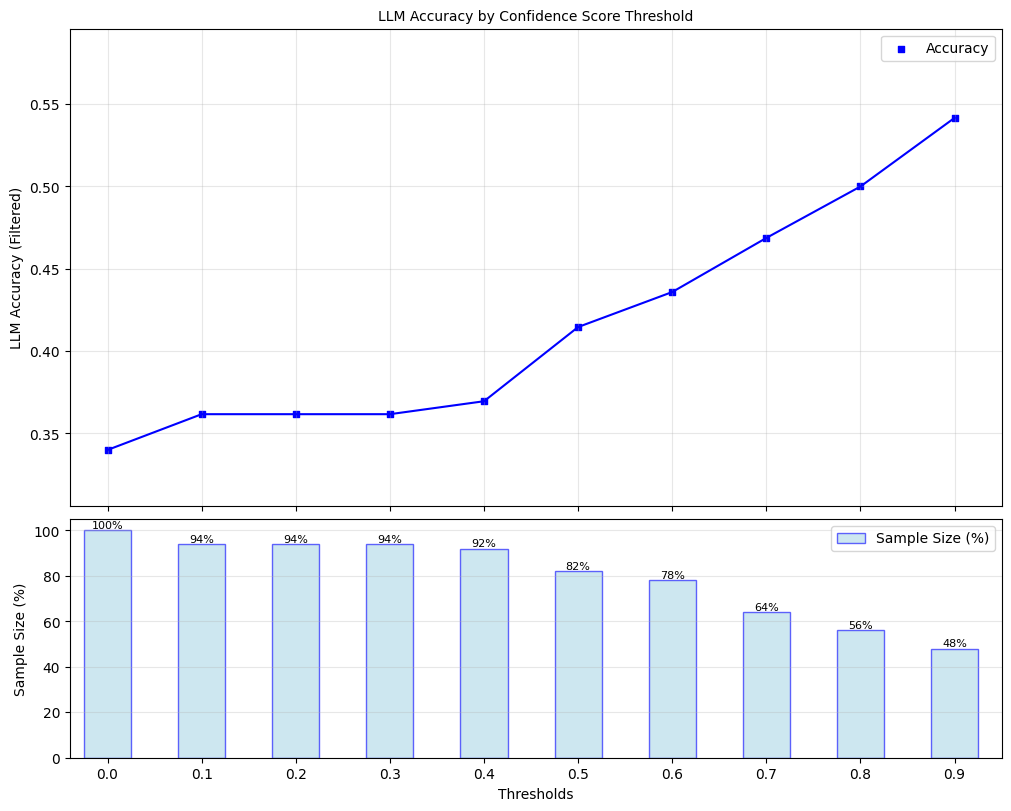

In [12]:
# Semantic Density
plot_model_accuracies(scores=result_df.semantic_density_value, correct_indicators=result_df.response_correct, display_percentage=True)

#### 3.2 Precision, Recall, F1-Score of Hallucination Detection

Lastly, we compute the optimal threshold for binarizing confidence scores, using F1-score as the objective. Using these thresholds, we compute precision, recall, and F1-score for our semantic density-based scorer predictions of whether responses are correct.

In [13]:
# instantiate UQLM tuner object for threshold selection
split = len(result_df) // 2
t = Tuner()

correct_indicators = (result_df.response_correct) * 1  # Whether responses is actually correct
metric_values = {"Precision": [], "Recall": [], "F1-score": []}
optimal_thresholds = []

# tune threshold on first half
y_scores = result_df["semantic_density_value"]
y_scores_tune = y_scores[0:split]
y_true_tune = correct_indicators[0:split]
best_threshold = t.tune_threshold(y_scores=y_scores_tune, correct_indicators=y_true_tune, thresh_objective="fbeta_score")

y_pred = [(s > best_threshold) * 1 for s in y_scores]  # predicts whether response is correct based on confidence score
optimal_thresholds.append(best_threshold)

# evaluate on last half
y_true_eval = correct_indicators[split:]
y_pred_eval = y_pred[split:]
metric_values["Precision"].append(precision_score(y_true=y_true_eval, y_pred=y_pred_eval))
metric_values["Recall"].append(recall_score(y_true=y_true_eval, y_pred=y_pred_eval))
metric_values["F1-score"].append(f1_score(y_true=y_true_eval, y_pred=y_pred_eval))

# print results
header = f"{'Metrics':<25}" + f"{'semantic_density_value':<35}"
print("=" * len(header) + "\n" + header + "\n" + "-" * len(header))
for metric in metric_values.keys():
    print(f"{metric:<25}" + "".join([f"{round(x_, 3):<35}" for x_ in metric_values[metric]]))
print("-" * len(header))
print(f"{'F-1 optimal threshold':<25}" + "".join([f"{round(x_, 3):<35}" for x_ in optimal_thresholds]))
print("=" * len(header))

Metrics                  semantic_density_value             
------------------------------------------------------------
Precision                0.615                              
Recall                   0.667                              
F1-score                 0.64                               
------------------------------------------------------------
F-1 optimal threshold    0.95                               


## 4. Scorer Definition
### Semantic Density
Semantic Density (SD) approximates a probability density function (PDF) in semantic space for estimating response correctness. Given a prompt $x$ with candidate response $y_*$, the objective is to construct a PDF that assigns higher density to regions in the semantic space that correspond to correct responses. We begin by sampling $M$ unique reference responses $y_i$ (for $i = 1, 2, \dots, M$) conditioned on $x$. For any pair of responses $y_i, y_j$ with corresponding embeddings $v_i, v_j$, the semantic distance is estimated as

\begin{equation}
    \mathbb{E}(\Vert v_i,v_j \Vert^2) = p_c(y_i, y_j | x) + \dfrac{1}{2} \cdot p_n(y_i, y_j | x)
\end{equation}

where $p_c, p_n$ denote the contradiction and neutrality scores returned by a natural language inference (NLI) model, respectively. This estimated distance is incorporated in the kernel function $K$ to smooth out the reference responses into a continuous distribution. The kernel function value can be obtained as

\begin{equation}
    K(v_*, v_i) = (1 - \mathbb{E}(\Vert v_* - v_i \Vert^2))\mathbf{1}_{\mathbb{E}(\Vert v_* - v_i \Vert) \leq 1}
\end{equation}

where $\bf{1}$ is the indicator function such that $\bf{1}_{\text{condition}} = 1$ when the condition holds and $0$ otherwise. The final semantic density score is computed as

\begin{equation}
    SD(y_* | x) = \dfrac{1}{\sum^M_{i=1}\sqrt[L_i]{p(y_i|x)}}\sum^M_{i=1}\sqrt[L_i]{p(y_i|x)}K(v_* - v_i)
\end{equation}

where $L_i$ denotes the length of $y_i$.

© 2025 CVS Health and/or one of its affiliates. All rights reserved.

© 2025 CVS Health and/or one of its affiliates. All rights reserved.